In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
import torch.nn.functional as F

In [2]:
path = '../input/'
tr = pd.read_csv(path + 'train.csv')
print(len(tr))
tr.head()

50272


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [3]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop = True)
df_train.head()
len(df_train)

7095

In [4]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
df_train = df_train[df_train['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4')].reset_index(drop=True)
print(len(df_train))
df_train.head()

801


,ImageId_ClassId,EncodedPixels
0,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
1,0025bde0c.jpg_4,315139 8 315395 15 315651 16 315906 17 316162 ...
2,002af848d.jpg_4,290800 6 291055 13 291311 15 291566 18 291822 ...
3,0030401a5.jpg_4,186833 1 187089 3 187344 6 187600 7 187855 10 ...
4,008621629.jpg_4,215548 3 215798 9 216051 12 216306 13 216560 1...


In [5]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [6]:
class ImageData(Dataset):
    def __init__(self, df, transform, subset = 'train'):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'

    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        fn = self.df['ImageId_ClassId'].iloc[index].split('_')[0]
        img = Image.open(self.data_path + fn)
        img = self.transform(img)
        
        if self.subset == 'train':
            mask = rle2mask(self.df['EncodedPixels'].iloc[index],(256, 1600))
            mask = transforms.ToPILImage()(mask)
            mask = self.transform(mask)
            return img, mask
        else:
            mask = None
            return img


In [7]:
data_transf = transforms.Compose([
                                  transforms.Resize((128,800)),
                                  transforms.ToTensor()])
train_data = ImageData(df = df_train, transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size=1)

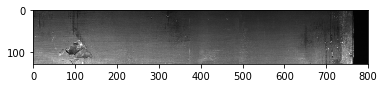

In [8]:
plt.imshow(train_data[5][0].permute(1,2,0))


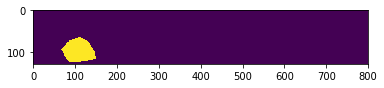

In [9]:
plt.imshow(np.squeeze(train_data[5][1].permute(1, 2, 0)))

In [10]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding = padding),
        nn.ReLU(inplace = True),
    )

In [11]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        self.base_model.load_state_dict(torch.load("../input/resnet18.pth"))
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [12]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNetResnet50(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [13]:
model = UNetResnet50(n_class=1).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = 0.001, momentum=0.9)

In [14]:
%%time
for epoch in range(2):      
    model.train()         
    for ii, (data, target) in enumerate(train_loader):                         
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)  
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()          
    print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, loss.item()))

Epoch: 1 - Loss: 0.002064
Epoch: 2 - Loss: 0.001664
CPU times: user 7min 23s, sys: 535 ms, total: 7min 24s
Wall time: 5min 31s


In [15]:
torch.save(model, './model_save/1-raw-5epoch-train-resnet50.pth')

/home/merto/anaconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type UNetResnet50. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
model = torch.load('./model_save/1-raw-5epoch-train-resnet50.pth')
model.eval()
print('done')

done


In [45]:
%matplotlib qt
sample_number = 100
plt.imshow(train_data[sample_number][0].permute(1, 2, 0))

In [46]:
%matplotlib qt
x = train_data[sample_number][0].unsqueeze(0)
o = model(x.cuda())  
o = o.cpu().detach().numpy() * (-1)
tmp = np.copy(o)
mn = np.mean(o)*1.2
tmp[tmp<mn] = 0
tmp[tmp>mn] = 1
plt.imshow(np.squeeze(tmp))

In [19]:
submit = pd.read_csv(path + 'sample_submission.csv', converters={'EncodedPixels': lambda e: ' '})
print(len(submit))
sub = submit[submit['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4' or x.split('_')[1] == '3' or x.split('_')[1] == '2' or x.split('_')[1] == '1')]
print(len(sub))
sub.head()

7204
7204


,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,
1,004f40c73.jpg_2,
2,004f40c73.jpg_3,
3,004f40c73.jpg_4,
4,006f39c41.jpg_1,


In [20]:
test_data = ImageData(df = sub, transform = data_transf, subset="test")
test_loader = DataLoader(dataset = test_data, shuffle=False)

In [21]:
%%time
predict = []
model.eval()
for data in test_loader:
    data = data.cuda()
    output = model(data)  
    output = output.cpu().detach().numpy() * (-1)    
    predict.append(abs(output[0]))

KeyboardInterrupt: 

In [22]:
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [23]:
%%time
pred_rle = []
  
for p in predict:        
    img = np.copy(p)
    mn = np.mean(img)*1.2
    img[img<=mn] = 0
    img[img>mn] = 1
    img = cv2.resize(img[0], (1600, 256))
    
    pred_rle.append(mask2rle(img))

KeyboardInterrupt: 

In [24]:
submit['EncodedPixels'][submit['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4')] = pred_rle
submit.head()

ValueError: cannot assign mismatch length to masked array

In [ ]:
img_s = cv2.imread( path + 'test_images/'+ submit['ImageId_ClassId'][47].split('_')[0])
plt.imshow(img_s)

In [ ]:
mask_s = rle2mask(submit['EncodedPixels'][47], (256, 1600))
plt.imshow(mask_s)